<a href="https://colab.research.google.com/github/cfong32/key-sentence-extraction/blob/main/exp7_save_gpt_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

This notebook downloads the CNN/DM dataset from Hugging Face and queries every sentence's text embedding from openai's api.

The whole process can cost $5 of credit at openai.com.

# Install and Import

In [3]:
!pip install -q datasets rouge_score openai

In [4]:
# import packages

import openai
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datasets import load_dataset
from spacy.lang.en import English
from sklearn.metrics.pairwise import cosine_similarity
from functools import partial
from time import sleep
pd.set_option('display.min_rows', 4)
tqdm.pandas()
tqdm = partial(tqdm, position=0, leave=True)

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


# Download dataset and split it into sentences

In [5]:
# load dataset into a dataframe

DATASET = 'cnn_dailymail'
CONFIG  = '3.0.0'
SUBSET  = 'test'

dataset = load_dataset(DATASET, CONFIG, split=SUBSET)
df = pd.DataFrame(dataset)
df

,article,highlights,id
0,(CNN)The Palestinian Authority officially beca...,Membership gives the ICC jurisdiction over all...,f001ec5c4704938247d27a44948eebb37ae98d01
1,(CNN)Never mind cats having nine lives. A stra...,"Theia, a bully breed mix, was apparently hit b...",230c522854991d053fe98a718b1defa077a8efef
...,...,...,...
11488,"Despite the hype surrounding its first watch, ...",Apple sold more than 61 million iPhones in the...,30ec5f280eee772a73d181bfc8514defd8026434
11489,Angus Hawley's brother has spoken of his shock...,Angus Hawley's brother said his late sibling '...,b4a1738c4a0acdf3d189264a0927005aa5b856d6


In [6]:
# split articles into sentences
# every entry of df['sentences'] will contain a list of strings

spacy_eng_nlp = English()
spacy_eng_nlp.add_pipe("sentencizer")

df['sentences'] = df.progress_apply(
    lambda x: (
        [str(s) for s in spacy_eng_nlp(x.article).sents]
    ),
    axis=1
)
df

100%|██████████| 11490/11490 [00:43<00:00, 264.23it/s]


,article,highlights,id,sentences
0,(CNN)The Palestinian Authority officially beca...,Membership gives the ICC jurisdiction over all...,f001ec5c4704938247d27a44948eebb37ae98d01,[(CNN)The Palestinian Authority officially bec...
1,(CNN)Never mind cats having nine lives. A stra...,"Theia, a bully breed mix, was apparently hit b...",230c522854991d053fe98a718b1defa077a8efef,"[(CNN)Never mind cats having nine lives., A st..."
...,...,...,...,...
11488,"Despite the hype surrounding its first watch, ...",Apple sold more than 61 million iPhones in the...,30ec5f280eee772a73d181bfc8514defd8026434,"[Despite the hype surrounding its first watch,..."
11489,Angus Hawley's brother has spoken of his shock...,Angus Hawley's brother said his late sibling '...,b4a1738c4a0acdf3d189264a0927005aa5b856d6,[Angus Hawley's brother has spoken of his shoc...


In [7]:
# get all individual sentences
all_sentences = []
for i, row in df.iterrows():
    all_sentences += row['sentences']

# make a dataframe of sentences
df_sent = pd.DataFrame({
    'sentence': all_sentences,
    'embedding': [np.NaN]*len(all_sentences)
})
df_sent

,sentence,embedding
0,(CNN)The Palestinian Authority officially beca...,NaN
1,The formal accession was marked with a ceremon...,NaN
...,...,...
387370,Daily Mail Australia has contacted the Kidman ...,NaN
387371,"Tribute: A good friend of Mr Hawley, Merivale ...",NaN


# Get openai's (GPT) embeddings 

In [8]:
# check connection and authentication with openai
MODEL_TO_USE = 'text-embedding-ada-002'
API_KEY = open('api_key.txt').read()        # the api_key is in a separate txt file

openai.api_key = API_KEY
res = [obj for obj in openai.Engine.list()['data']
       if obj['id'] == MODEL_TO_USE][0]
print(res)

{
  "created": null,
  "id": "text-embedding-ada-002",
  "object": "engine",
  "owner": "openai-internal",
  "permissions": null,
  "ready": true
}


In [18]:
# request for openai's embeddings through api #

BATCH_SIZE = 2000    # sentences per api request

# this loop saves received embeddings every iteration
# when error occurs at any request (iteration), just re-run the loop and
# it will skip those saved batches and start from the batch which error occured
for i in range(0, len(df_sent), BATCH_SIZE):
    start, stop = i, min(i+BATCH_SIZE, len(df_sent))
    print(f'from: {start}, to: {stop}')

    # skip if results of this batch has saved
    if df_sent.loc[start:stop, 'embedding'].notna().all():
        continue

    sentences_to_query = df_sent.loc[start:stop].sentence.tolist()
    res = openai.Embedding.create(
        input=sentences_to_query,
        engine=MODEL_TO_USE
    )
    X = np.array([r['embedding'] for r in res['data']])

    for j, k in enumerate(range(start, stop)):
        df_sent.at[k, 'embedding'] = X[j]
    
    sleep(1)    # avoid requesting too fast

from: 0, to: 2000
from: 2000, to: 4000
from: 4000, to: 6000
from: 6000, to: 8000
from: 8000, to: 10000
from: 10000, to: 12000
from: 12000, to: 14000
from: 14000, to: 16000
from: 16000, to: 18000
from: 18000, to: 20000
from: 20000, to: 22000
from: 22000, to: 24000
from: 24000, to: 26000
from: 26000, to: 28000
from: 28000, to: 30000
from: 30000, to: 32000
from: 32000, to: 34000
from: 34000, to: 36000
from: 36000, to: 38000
from: 38000, to: 40000
from: 40000, to: 42000
from: 42000, to: 44000
from: 44000, to: 46000
from: 46000, to: 48000
from: 48000, to: 50000
from: 50000, to: 52000
from: 52000, to: 54000
from: 54000, to: 56000
from: 56000, to: 58000
from: 58000, to: 60000
from: 60000, to: 62000
from: 62000, to: 64000
from: 64000, to: 66000
from: 66000, to: 68000
from: 68000, to: 70000
from: 70000, to: 72000
from: 72000, to: 74000
from: 74000, to: 76000
from: 76000, to: 78000
from: 78000, to: 80000
from: 80000, to: 82000
from: 82000, to: 84000
from: 84000, to: 86000
from: 86000, to: 88000


In [20]:
df_sent

,sentence,embedding
0,(CNN)The Palestinian Authority officially beca...,"[-0.0017101807752624154, -0.012141488492488861..."
1,The formal accession was marked with a ceremon...,"[0.007933792658150196, -0.010312643833458424, ..."
...,...,...
387370,Daily Mail Australia has contacted the Kidman ...,"[-0.022104516625404358, -0.010163666680455208,..."
387371,"Tribute: A good friend of Mr Hawley, Merivale ...","[-0.025303861126303673, -0.0009077293798327446..."


# Check results

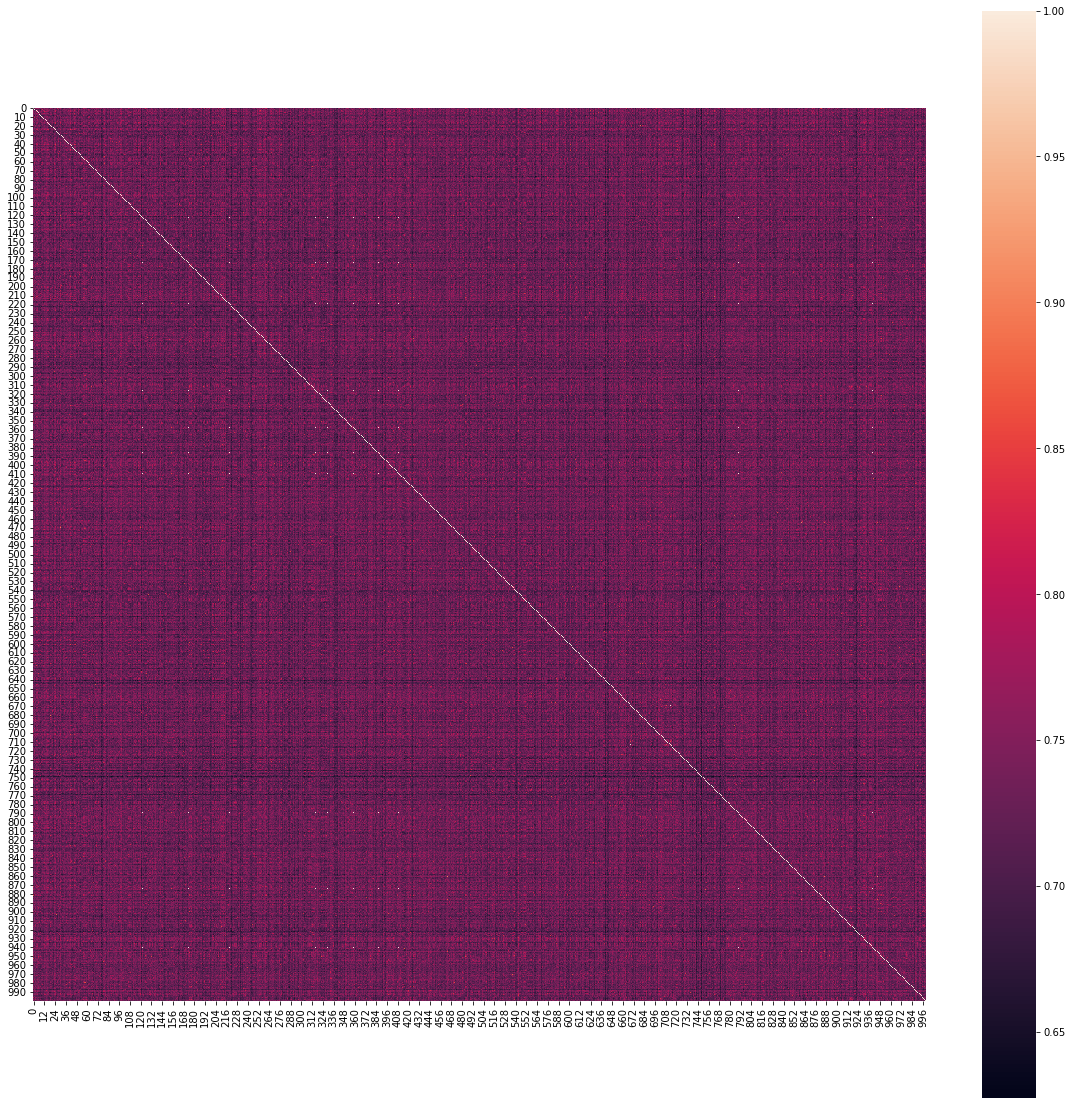

In [27]:
# sentence-to-sentence similarities

def fix_ndarray(emb_values):
    return np.array([[u for u in v] for v in emb_values])
    
df_sampled = df_sent.sample(1000)
X = fix_ndarray(df_sampled.embedding.values)
A = cosine_similarity(X, X)

plt.figure(figsize=(20,20))
sns.heatmap(A)
plt.gca().set_aspect('equal')
plt.show()

Text(0.5, 1.0, 'distribution of sampled cos-sim')

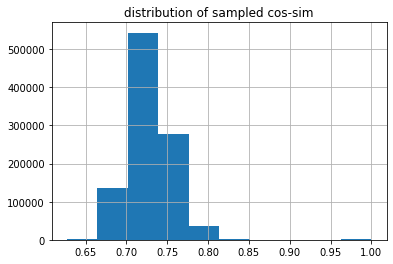

In [34]:
# histogram

pd.Series(A.flat).hist()
plt.title('distribution of sampled cos-sim')

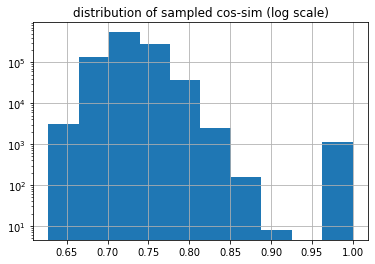

In [33]:
# histogram (log scale)

pd.Series(A.flat).hist()
plt.yscale('log')
plt.title('distribution of sampled cos-sim (log scale)')
plt.show()

In [31]:
## save to pickle
# df_sent.to_pickle('exp7.dfpkl')

In [ ]:
## for backup
# from google.colab import drive
# drive.mount('/content/gdrive')
# !cp exp7.230226.1803.dfpkl /gdrive/MyDrive/Shared/